# Analyser les données
Si lors de la partie du scraping, on se contentait uniquement de récupérer la données, ici l'objectif sera de la traiter pour la rendre accessible et ainsi faire des analyses dessus. Car en l'état un tweet est très peu exploitable, de la même manière qu'on ne veut pas de tout les tweets récoltés, mais seulement une portion.


## Mise en place

In [1]:
import pandas as pd
import uuid
import requests
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk import ngrams
import unicodedata
import re
from collections import Counter
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("test_2024-08-04_11-29-53.csv")
df['content'] = df['content'].astype(str)
df.head()

df2 = pd.read_csv("test_2024-08-05_09-50-26.csv")
df2['content'] = df2['content'].astype(str)

In [3]:
df['tweet_id'] = None
for i, row in df.iterrows():
    if row['tweet_type']=='Normal':
        id = uuid.uuid4()
        df.loc[i, 'tweet_id'] = id
    
    if row['tweet_type']=="Réponse":
        df.loc[i, 'tweet_id'] = df.loc[i-1, 'tweet_id']

In [4]:
df2['tweet_id'] = None
for i, row in df2.iterrows():
    if row['tweet_type']=='Normal':
        id = uuid.uuid4()
        df2.loc[i, 'tweet_id'] = id
    
    if row['tweet_type']=="Réponse":
        df2.loc[i, 'tweet_id'] = df2.loc[i-1, 'tweet_id']

In [6]:
df_f = pd.concat([df, df2])
df_f.reset_index(drop=True, inplace=True)

print(df_f.shape)
df_f.drop_duplicates(subset=['content', 'time_posted'], inplace=True)
print(df_f.shape)


(2334, 10)
(2324, 10)


Ici on créer un dictionnaire qui, pour chacune des gares de la ligne du RER A associe toutes les manières de l'écrire possible. Par exemple Boissy-Saint-Léger peut aussi être écrit comme Boissy-St-Léger, ce sont 2 orthographes différentes pour une même ; on répète ce processus pour toutes les gares.
Ce dictionnaire permettra de facilement trouver la gare mentionnée dans un tweet.

In [5]:
stations_rer_a_constant_dict = {
    "Achères Grand Cormier":["Achères Grand Cormier"],
    "Achères Ville" : ["Achères Ville"],
    "Auber" : ["Auber"],
    "Boissy-Saint-Léger" : ["Boissy-Saint-Léger", "Boissy-St-Léger", "Boissy", "Poissy Saint Léger"],
    "Bry-sur-Marne": ["Bry-sur-Marne"],
    "Bussy-Saint-Georges": ["Bussy-Saint-Georges", "Bussy-St-Georges"],
    "Cergy le Haut" : ["Cergy le Haut", "Cergy"],
    "Cergy Préfecture" : ["Cergy Préfecture"],
    "Cergy Saint-Christophe" : ["Cergy Saint-Christophe", "Cergy St-Christophe"],
    "Champigny": ["Champigny"],
    "Charles de Gaulle-Etoile" : ["Charles de Gaulle-Etoile"],
    "Châtelet les Halles" : ["Châtelet les Halles"],
    "Chatou-Croissy" : ["Chatou-Croissy"],
    "Conflans Fin d'Oise" : ["Conflans Fin d'Oise", "Conflans – Fin d’Oise"],
    "Fontenay-sous-Bois" : ["Fontenay-sous-Bois", "Fontenay"],
    "Gare de Lyon" : ["Gare de Lyon"],
    "Houilles-Carrières-sur-Seine" : ["Houilles-Carrières-sur-Seine", "Houilles"],
    "Joinville-le-Pont" : ["Joinville-le-Pont"],
    "La Défense" : ["La Défense", "Défense"],
    "La Varenne-Chennevières" :["La Varenne-Chennevières", "Varenne-Chennevières", "Varennes Chennevieres"],
    "Parc de Saint-Maur" : ["Parc de Saint-Maur", "Parc de St-Maur", "Parc Saint-Maur", "Parc St-Maur"],
    "Le Vésinet-Centre" : ["Le Vésinet-Centre", "Vésinet-Centre"],
    "Le Vésinet-Le Pecq" : ["Le Vésinet-Le Pecq", "Vésinet-Le Pecq"],
    "Lognes": ["Lognes"],
    "Maisons-Laffitte" : ["Maisons-Laffitte", "Maison-Laffitte", "Maisons-Laffite", "Maison-Laffite"],
    "Marne-la-Vallée-Chessy" : ["Marne-la-Vallée-Chessy", "MLV-Chessy", "Marne la Vallée", "Chessy"],
    "Nanterre Préfecture" : ['Nanterre Préfecture', "Nantere Pref", "Nanterre-P"],
    "Nanterre Université" : ["Nanterre Université"],
    "Nanterre Ville" : ["Nanterre Ville"],
    "Nation" : ["Nation"],
    "Neuilly-Plaisance" : ["Neuilly-Plaisance"],
    "Neuville Université": ["Neuville Université"],
    "Nogent-sur-Marne" : ["Nogent-sur-Marne"],
    "Noisiel" : ["Noisiel"],
    "Noisy-Champs" : ["Noisy-Champs"],
    "Noisy-le-Grand-Mont d'Est" : ["Noisy-le-Grand-Mont d'Est", "Noisy-le-Grand"],
    "Poissy" : ["Poissy"],
    "Rueil-Malmaison" : ["Rueil-Malmaison"],
    "Saint-Germain-en-Laye" : ["Saint-Germain-en-Laye", "St-Germain-En-Laye", "St Germain", "Saint Germain"],
    "Saint-Maur-Créteil" : ["Saint-Maur-Créteil", "St-Maur-Créteil"],
    "Sartrouville" : ["Sartrouville"],
    "Sucy-Bonneuil" : ["Sucy-Bonneuil"],
    "Torcy" : ["Torcy"],
    "Val d'Europe" : ["Val d'Europe"],
    "Val de Fontenay" : ["Val de Fontenay"],
    "Vincennes" : ["Vincennes"],
}

## Nettoyage
Après avoir importé les données et créé un premier référentiel, il est temps de nettoyer les données.
Les étapes de nettoyage seront décrite au fur et à mesure.

### Création d'une fonction
Pour simplifier le processus, une fonction est créée rassemblant les étapes principales du nettoyage de données. On y retrouve la mise en minuscule, la normalisation en remplacant les caractères accentués, retirer les chiffres ou espaces supllémentaires...
Cette première fonction permettra de mettre les données à un même stade.

In [ ]:
def clean_text(text):
    text = text.lower()
    text = text.replace('–', '-')
    text = text.replace('\n', ' ')
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode("utf-8")
    text = re.sub(r'[^\w\s]',' ',text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s{2,}', ' ', text)
    return text

### Nettoyer le réferentiel
Comme le référentiel des gares n'est pas totalement propre, il passe par la fonction de nettoyage, de cette manière lorsqu'on nettoiera les données de tweet, les différentes orthogrpahe de gares auront les mêmes caractéristiques.

In [ ]:
stations_rer_a_cleaned_dict = stations_rer_a_constant_dict.copy()
for key, value in stations_rer_a_cleaned_dict.items():
    stations_rer_a_cleaned_dict[key] = [clean_text(station) for station in value]
df_f['content_cleaned'] = df_f['content'].apply(clean_text)

NameError: name 'df_f' is not defined

### Détecter les gares
L'objectif du référentiel est de pouvoir retrouver les gares mentionnées dans les tweets. Eh bien, c'est ce qui va être fait ici !
Comme plusieurs gares peuvent apparaître dans un tweet, il est nécessaire d'itérer sur toutes les gares du référentiel et de noter la clé du dictionnaire associés comme occurrence.
Le problème avec ça est que dans le cas où la gare "Boissy Saint Léger" sera mentionnée, comme dans ses appellations il y a "Boissy" et "Boissy Saint Léger" on peut voir qu'une possibilité d'occurrence est contenue dans l'autre. C'est à dire que pour cette gare on comptera 2 occurrences.

Pour éviter ce problème, la solution employée (qui n'est pas la plus optimale) et de vérifier le contenu du texte à l'aide d'une fénetre s'étendant d'un caractère vers la droite tant que rien n'est trouvé. Si une gare est trouvée dans cette fenêtre, on note la gare, et la nouvelle fenêtre de recherche commencera à la fin de la gare trouvée. De cette manière on évite d'itérer sur une gare déjà trouvée.


#### Tester la fonction de fenêtrage

In [9]:
current_text = "les trains actuellement entre bussy saint georges et marne la vallee chessy et en direction de marne la vallee chessy stationnent en raison d une panne electrique a marne la vallee chessy rera"

cursor_deb = 0
cursor_end = 1


def find_gare(text):
    for gare_key in stations_rer_a_cleaned_dict.keys():
        for gare2 in stations_rer_a_cleaned_dict[gare_key]:
            if gare2 in text:
                return gare2, gare_key
    return None, None


def find_max_len_gare_from_key(gare_key, gare_matched, text, cursor_deb, cursor_end):
    current_len = len(gare_matched)

    temp_list = stations_rer_a_cleaned_dict[gare_key].copy()
    temp_list.sort(key=len, reverse=True)
    max_len_gare = temp_list[0]
    diff_len = len(max_len_gare) - current_len

    cursor_end2 = cursor_end + diff_len

    new_text = text[cursor_deb:cursor_end2]
    for gare in temp_list:
        if gare in new_text:
            return gare, cursor_end2
                

while cursor_end < len(current_text):

    ## Find gare between cursor_deb and cursor_end
    gare, gare_key = find_gare(current_text[cursor_deb:cursor_end])

    if gare is None:
        cursor_end += 1
    else:
        gare, cursor_end = find_max_len_gare_from_key(gare_key, gare, current_text, cursor_deb, cursor_end)
        print(gare)
        cursor_deb = cursor_end
        cursor_end = cursor_deb + 1 
                
                

bussy saint georges
marne la vallee chessy
marne la vallee chessy
marne la vallee chessy


#### Application de la fonction de fenêtrage

In [10]:
for index, row in df_f.iterrows():
    current_text = row['content_cleaned']
    cursor_deb = 0
    cursor_end = 1

    gare_detected = []

    while cursor_end < len(current_text):

        gare, gare_key = find_gare(current_text[cursor_deb:cursor_end])

        if gare is None:
            cursor_end += 1
        else:
            gare, cursor_end = find_max_len_gare_from_key(gare_key, gare, current_text, cursor_deb, cursor_end)
            gare_detected.append(gare_key)
            cursor_deb = cursor_end
            cursor_end = cursor_deb + 1 

    df_f.loc[index, 'gare_detected'] = ",".join(gare_detected)


In [ ]:
df_f['nb_gare_detected'] = df_f['gare_detected'].apply(lambda x: len(x.split(',')))
df_f.groupby(['tweet_type', 'nb_gare_detected']).size()

In [15]:

"""
for index, row in df_f.iterrows():
    tweet_text = row['content_cleaned']
    tweet_len = len(tweet_text)

    cursor_begin = 0
    cursor_end = 0

    gare_detec = []

    while cursor_end <= tweet_len:
        current_text = tweet_text[cursor_begin:cursor_end]

        for gare_key in stations_rer_a_cleaned_dict.keys():

            gare = ""
            # marne la vallee chessy ne matche pas alors que, marne la vallee et chessy matchent
            for gare2 in stations_rer_a_cleaned_dict[gare_key]:
                if gare2 in current_text:
                    gare = gare2
                    if tweet_text == "les trains actuellement entre bussy saint georges et marne la vallee chessy et en direction de marne la vallee chessy stationnent en raison d une panne electrique a marne la vallee chessy rera":
                        print(gare)
                    break

            if gare == "":
                continue
                    
            temp_list = stations_rer_a_cleaned_dict[gare_key].copy()
            temp_list.sort(key=len, reverse=True)
            
            max_len_gare = len(temp_list[0])
            diff_len = max_len_gare - len(gare)

            best_gare_name_len = 0
            best_gare_name = ""
            for gare2 in stations_rer_a_cleaned_dict[gare_key]:
                if gare2 in tweet_text[cursor_begin:cursor_end+diff_len]:
                    if len(gare2) > best_gare_name_len:
                        best_gare_name_len = len(gare2)
                        best_gare_name = gare2

                
            gare_detec.append(gare_key)
            cursor_begin = cursor_end+(max_len_gare-len(best_gare_name))
                    

        cursor_end += 1
    df_f.loc[index, 'gare_detected'] = ",".join(gare_detec)
"""

bussy saint georges
marne la vallee
chessy
marne la vallee
chessy
marne la vallee
chessy


In [34]:
"""df_f['gare_detected'] = ""
for index, row in df_f.iterrows():
    gare_detec = []

    tweet_text = row['content_cleaned']
    for gare_key in stations_rer_a_cleaned_dict.keys():
        for gare in stations_rer_a_cleaned_dict[gare_key]:
            if gare in row['content_cleaned']:
                gare_detec.append((gare, gare_key))
            break

    details = []
    for gare_detected in gare_detec:
        index_deb = tweet_text.find(gare_detected[0])
        index_fin = index_deb + len(gare_detected[0])

        details.append((gare_detected, index_deb, index_fin))

    details = sorted(details, key=lambda x: x[1])

    details_copy = details.copy()

    print(details)
    for index, detail in enumerate(details[1:]):
        index_deb = detail[1]
        index_fin = detail[2]

        old_deb = details[index][1]
        old_fin = details[index][2]   

        if index_deb >= old_deb and index_fin <= old_fin:
            details_copy.remove(detail)
        
    print(details_copy)

    final_gare_detec = [detail[0][1] for detail in details_copy]
    df_f.loc[index, 'gare_detected'] = ",".join(final_gare_detec)"""

'df_f[\'gare_detected\'] = ""\nfor index, row in df_f.iterrows():\n    gare_detec = []\n\n    tweet_text = row[\'content_cleaned\']\n    for gare_key in stations_rer_a_cleaned_dict.keys():\n        for gare in stations_rer_a_cleaned_dict[gare_key]:\n            if gare in row[\'content_cleaned\']:\n                gare_detec.append((gare, gare_key))\n            break\n\n    details = []\n    for gare_detected in gare_detec:\n        index_deb = tweet_text.find(gare_detected[0])\n        index_fin = index_deb + len(gare_detected[0])\n\n        details.append((gare_detected, index_deb, index_fin))\n\n    details = sorted(details, key=lambda x: x[1])\n\n    details_copy = details.copy()\n\n    print(details)\n    for index, detail in enumerate(details[1:]):\n        index_deb = detail[1]\n        index_fin = detail[2]\n\n        old_deb = details[index][1]\n        old_fin = details[index][2]   \n\n        if index_deb >= old_deb and index_fin <= old_fin:\n            details_copy.remove

### Retirer les mots sans importance
Pour continuer l'étude du contenu, il est temps de maintenant retirer les mots sans importance des tweets, ce qui n'apporte pas de sémantique.
Si la liste de stopowrds français est assez exhaustive et permet de retirer la majorité des mots inutiles des tweets, cette liste ne contient pas tout. Dans le contexte de la rechercher des incidents du RER A, d'autres mots sont nécessaires à exclure, comme par exemple : rera, actuellement, direction, train... Des mots qui dans le contexte du RER A apparaissent très régulièrement, mais n'apportent pas grand choses puisqu'ici on sait que nos données sont cadrées.

In [13]:
stopwords_list = stopwords.words('french')+['a', 'rera', 'actuellement', 'direction', 'vers', 'trafic', 'repercussion', "train", "trains", "paris", "h", "cela", "fait", "suite"]


critical_words = ['perturbe', 'raison', 'stationne', 'rer_a', 'entre', 'gare', 'marquent', 'arret', 'autre', 'heure', 'reprise', 'estimee', 'ensemble', 'ligne', 'prolonge', 'reste', 'interrompu', 'stationnent', 'stationnement', 'repart', 'terminus', 'desservie']

stopwords_list = stopwords_list + critical_words

def remove_stations(text):
    for gare_key in stations_rer_a_cleaned_dict:
        for station in stations_rer_a_cleaned_dict[gare_key]:
            text = text.replace(station, '')
    return text

def remove_stopwords(text):
    text = ([word for word in text.split() if word not in stopwords_list])
    return text


df_f['content_removed_gare'] = df_f['content_cleaned'].apply(remove_stations)
df_f['content_removed_sw'] = df_f['content_removed_gare'].apply(remove_stopwords)
df_f['content_cleand_str'] = df_f['content_removed_sw'].apply(lambda x:' '.join(x))

## Observation
Avant d'aller plus loin dans l'analyse, il est pertinent de faire une première observation sur le contenu de tous les tweets confondus. Pour voir la fréquences des mots utilisés, et par la même occasion vérifier qu'il ne reste pas de stopwords à retirer.

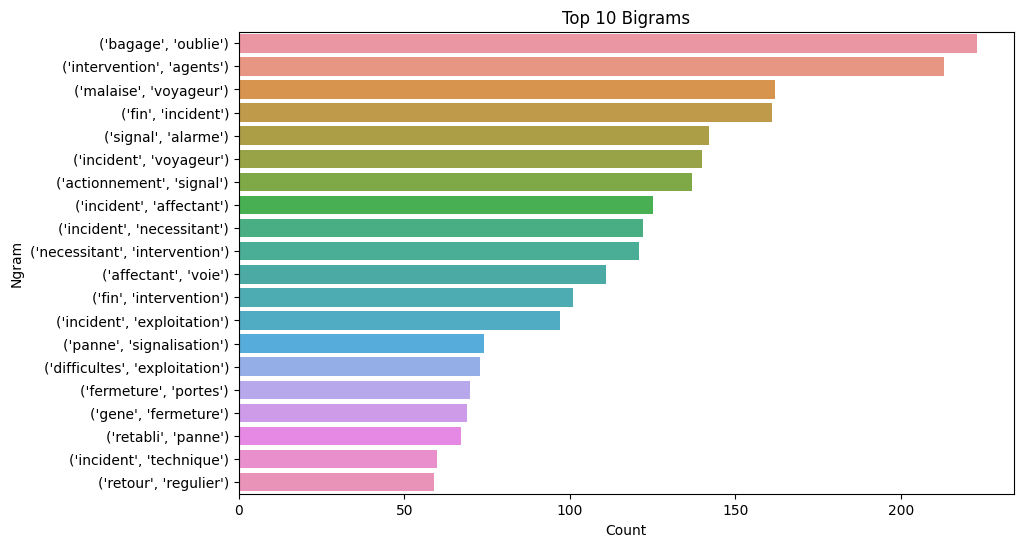

In [16]:
def count_words(text):
    return Counter(text)

def count_ngrams(text, n):
    n_grams = ngrams(text, n)
    return Counter(n_grams)

def plot_top_n(counter, n, title):
    common = counter.most_common(n)
    df_common = pd.DataFrame(common, columns=['Ngram', 'Count'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Ngram', data=df_common)
    plt.title(title)
    plt.show()



# Compter les occurrences des mots, bigrammes et trigrammes
df_f['word_counts'] = df_f['content_removed_sw'].apply(count_words)
df_f['bigram_counts'] = df_f['content_removed_sw'].apply(lambda x: count_ngrams(x, 2))
df_f['trigram_counts'] = df_f['content_removed_sw'].apply(lambda x: count_ngrams(x, 3))

# Agréger les compteurs
total_word_counts = sum(df_f['word_counts'], Counter())
total_bigram_counts = sum(df_f['bigram_counts'], Counter())
total_trigram_counts = sum(df_f['trigram_counts'], Counter())

# Afficher les graphiques
#plot_top_n(total_word_counts, 20, 'Top 10 Words')
plot_top_n(total_bigram_counts, 20, 'Top 10 Bigrams')
#plot_top_n(total_trigram_counts, 20, 'Top 10 Trigrams')

Ce graph nous donne des informations importantes quant aux bigram les plus utilisés, et les résultats sont plutot encourageants, puisqu'on voit directement une tendance se dessiner, celle-ci clairement articulée autour des incidents avec des mots comme : bagage oublie, malaise voyageur, signal alarme...

## Trier les tweets des incidents de ceux de sujets divers
L'étude des mots les plus courants peut nous aider dans cette tâche qui va être de séparer les tweets sur les incidents (qu'on souhaite garder) et ceux n'ayant pas les incidents pour thématiques (ceux dont on n'a pas besoin). A cette étape plusieurs solutions sont envisageables : clustering, transformer...Ici je vais utiliser une liste de termes que je vais affiner petit à petit pour être sûr d'includre/exclure les tweets voulus.

On va donc définir 2 listes de termes : une contenant des mots relatif aux incidents, une autres contenant des mots relatifs aux tweets divers. Si un tweet "principal" contient les mots d'une liste ou l'autre, on l'associe à la catégorie associée. Dans le cas où il ne correspond à aucune liste, cela ne change rien puisque cela signifiera qu'il est inutile. On aurait pu définir uniquement une liste de termes, mais pour s'assurer des mauvais tweet, la deuxième liste a été définie.

In [ ]:
df_tweet_normal = df_f[df_f['tweet_type']=='Normal']

words_problem = ['incident', 'oublie', 'perturbe', 'altercation', 'bagarre', 'alarme', 'intervention', 'voie', 'personne', 'malaise', 'inondations', 'panne', 'gene', 'fermeture', 'porte', 'difficulte', 'exploitation', 'rallongement', 'chantier', 'affluence', 'exceptionnelle', 'prefecture', 'police', 'catenaire', 'intervalle', 'retardee', 'degradation', 'regulation', 'fumee', 'securite', 'malveillance']


words_not_problem = ['mardiconseil', 'nouvelarticle', 'nouvel article','jeudiphoto', 'vendredilecture', 'jeu concours', 'hydrater', 'philosopher', 'solliciter', 'respecter', 'animation', 'tchat', 'blog', 'voir plus']

df_f['is_problem'] = False
for i, row in df_f.iterrows():
    if row['tweet_type']=='Normal':
        for word in words_problem:
            if word in row['content_cleand_str']:
                tweet_id = df_f.loc[i, 'tweet_id']
                df_f.loc[df_f['tweet_id']==tweet_id, 'is_problem'] = True

        for word in words_not_problem:
            if word in row['content_cleand_str']:
                tweet_id = df_f.loc[i, 'tweet_id']
                df_f.loc[df_f['tweet_id']==tweet_id, 'is_problem'] = False

In [18]:
df_f[(df_f['tweet_type']=='Normal') & (df_f['is_problem']==False)]['content_cleand_str'].values

array(['nouvelarticle saviez fortes chaleurs peuvent impacter infrastructures ainsi materiel roulant decouvrez tout nouvel article blog ici',
       'distributions eau prevues aujourd hui gares',
       'distributions eau prevues aujourd hui gares',
       'fortes chaleurs pensez hydrater avant arrivee emportez eau trajet restez attentifs envers autres voyageurs hesitez solliciter agents',
       'jeudiphoto prenons petit instant contempler vue aerienne sauriez deviner annee prise cette vue',
       'travaux calendrier travaux mois aout septembre disponible blog ici',
       'fortes chaleurs distributions bouteilles eau lieu gares agents',
       'distributions eau prevues aujourd hui gares',
       'fortes chaleurs pensez hydrater avant arrivee emportez eau trajet restez attentifs envers autres voyageurs hesitez solliciter agents',
       'animation decouvrez stadium ratp decouvrez tir arc badminton handfit tout',
       'fortes chaleurs pensez hydrater avant arrivee emportez eau traj

In [19]:
df_f[(df_f['tweet_type']=='Normal') & (df_f['is_problem']==True) & (df_f['nb_gare_detected']==3)][['content', 'content_cleand_str', 'gare_detected']].values

array([[" Le trafic est perturbé de Poissy vers Nanterre - Préfecture , en raison d'un incident d'exploitation à Poissy #RERA",
        'incident exploitation', 'Poissy,Nanterre Préfecture,Poissy'],
       ["Le trafic est perturbé de Boissy-saint-Léger vers la Varennes-Chennevières, en raison d'un incident d'exploitation à Boissy-Saint-Léger. #RERA",
        'incident exploitation',
        'Boissy-Saint-Léger,La Varenne-Chennevières,Boissy-Saint-Léger'],
       ["Le train actuellement à Nation et en direction de Boissy-Saint-Léger stationne en raison d'un bagage oublié sur le quai à Vincennes. #RERA",
        'bagage oublie quai', 'Nation,Boissy-Saint-Léger,Vincennes'],
       ["Le train actuellement à La Varenne–Chennevières et en direction de Boissy-Saint-Léger stationne en raison d'un incident technique à Sucy – Bonneuil. #RERA",
        'incident technique',
        'La Varenne-Chennevières,Boissy-Saint-Léger,Sucy-Bonneuil'],
       ["Le train actuellement entre Sucy – Bonneuil et

## Stats générales

Période de temps maximale : de 2024-03-29 14:26:35 à 2024-08-03 19:53:27


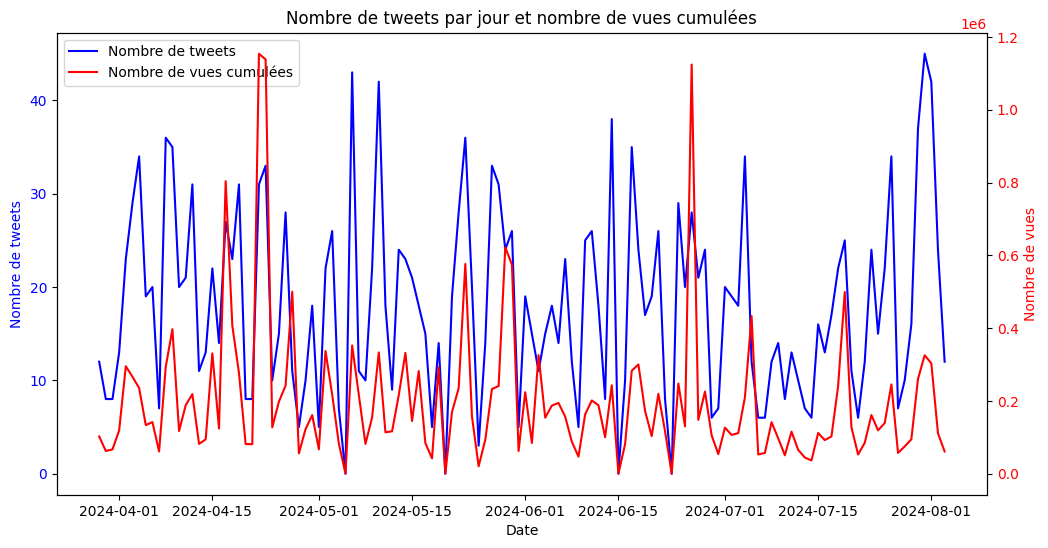

In [20]:
df_f['date'] = pd.to_datetime(df_f['time_posted'])
start_date = df_f['date'].min()
end_date = df_f['date'].max()

print(f"Période de temps maximale : de {start_date} à {end_date}")

# Compter le nombre de tweets par jour
tweets_per_day = df_f.set_index('date').resample('D').size()
views_per_day = df_f.set_index('date')['views'].resample('D').sum()



plt.figure(figsize=(12, 6))

# Créer le premier axe
ax1 = plt.subplot()
ax1.plot(tweets_per_day.index, tweets_per_day.values, label='Nombre de tweets', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Nombre de tweets', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Créer le second axe
ax2 = ax1.twinx()
ax2.plot(views_per_day.index, views_per_day.values, label='Nombre de vues cumulées', color='red')
ax2.set_ylabel('Nombre de vues', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Ajouter les titres et les légendes
plt.title('Nombre de tweets par jour et nombre de vues cumulées')

# Combiner les légendes des deux axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Afficher le graphique
plt.show()

count    2324.000000
mean        0.107842
std         0.099818
min         0.000000
25%         0.056504
50%         0.084984
75%         0.124254
max         1.550388
Name: engagement, dtype: float64


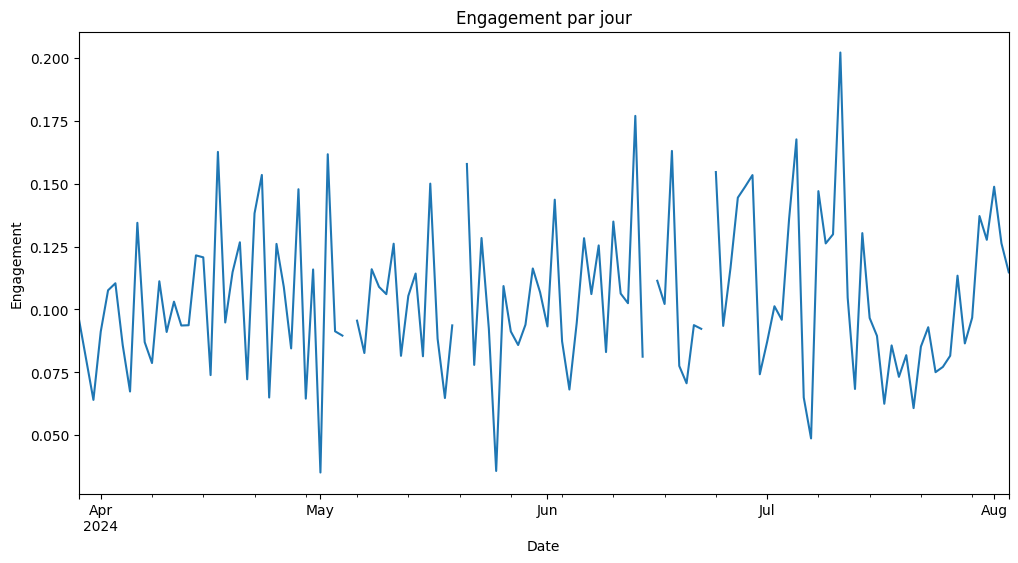

In [21]:
df_f['engagement'] = ((df_f['likes'] + df_f['retweets'] + df_f['comments']) / df_f['views'])*100

# Afficher des statistiques descriptives sur l'engagement
print(df_f['engagement'].describe())

# Tracer l'engagement au fil du temps
df_f['date'] = pd.to_datetime(df_f['time_posted'])
engagement_per_day = df_f.set_index('date')['engagement'].resample('D').mean()

plt.figure(figsize=(12, 6))
engagement_per_day.plot()
plt.title('Engagement par jour')
plt.xlabel('Date')
plt.ylabel('Engagement')
plt.show()

## Stats sur les incidents

In [22]:
tweet_incidents = df_f[df_f['is_problem']==True]
tweet_normaux_incidents = tweet_incidents[tweet_incidents['tweet_type']=='Normal']

C:\Users\gabriel\AppData\Local\Temp\ipykernel_4364\3611408497.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_normaux_incidents['date'] = pd.to_datetime(tweet_normaux_incidents['time_posted'])


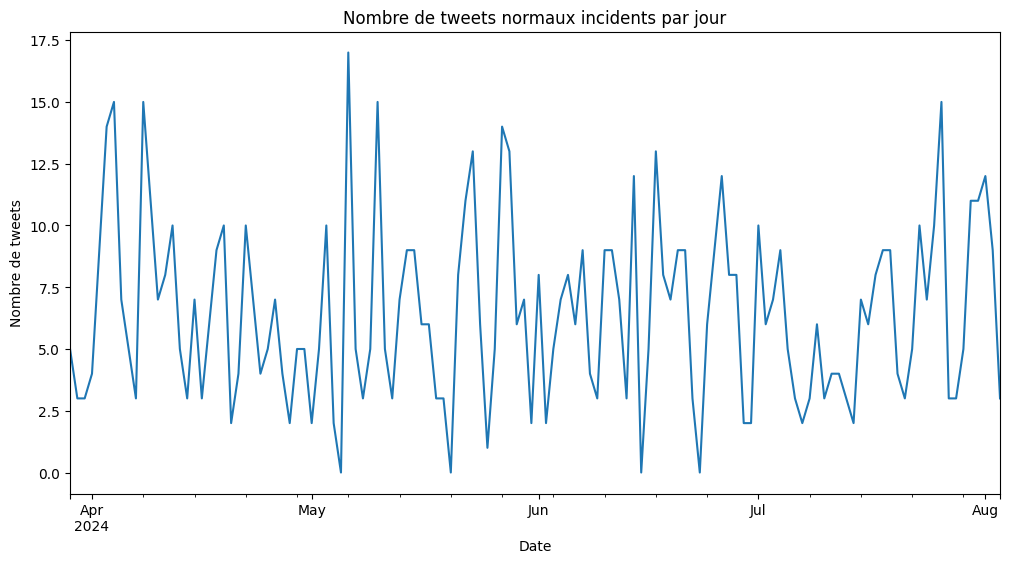

In [23]:
tweet_normaux_incidents['date'] = pd.to_datetime(tweet_normaux_incidents['time_posted'])

# Compter le nombre de tweets normaux incidents par jour
tweets_normaux_incidents_per_day = tweet_normaux_incidents.set_index('date').resample('D').size()

# Afficher le nombre de tweets normaux incidents par jour
plt.figure(figsize=(12, 6))
tweets_normaux_incidents_per_day.plot()
plt.title('Nombre de tweets normaux incidents par jour')
plt.xlabel('Date')
plt.ylabel('Nombre de tweets')
plt.show()

In [24]:
unique_id = tweet_incidents['tweet_id'].unique()
len(unique_id)

828

In [25]:
pb_resolve = {
    'id': [],
    'begin_date': [],
    'end_date': [],
    'duration': []
}
for id in unique_id:


    
    df_id = df_f[df_f['tweet_id']==id]

    begin_date = df_id[df_id['tweet_type']=='Normal']['date'].values[0]

    try:
        end_date = df_id[df_id['tweet_type']=='Réponse'].sort_values('date', ascending=False).iloc[0]['date']
    except Exception:
        continue

    pb_resolve['id'].append(id)
    pb_resolve['begin_date'].append(begin_date)
    pb_resolve['end_date'].append(end_date)
    pb_resolve['duration'].append(end_date - begin_date)


In [26]:
pb_resolve_df = pd.DataFrame.from_dict(pb_resolve)
pb_resolve_df.iloc[pb_resolve_df['duration'].idxmax()]

id            2c1ab6ce-f8b0-49e8-a146-73191cd37267
begin_date                     2024-06-17 10:47:51
end_date                       2024-06-18 04:21:29
duration                           0 days 17:33:38
Name: 286, dtype: object

In [27]:
pb_resolve_df['duration'].describe()

count                          768
mean     0 days 00:40:58.902343750
std      0 days 01:08:38.499840755
min                0 days 00:00:00
25%         0 days 00:03:18.750000
50%                0 days 00:13:21
75%         0 days 00:56:52.500000
max                0 days 17:33:38
Name: duration, dtype: object

In [28]:
Q1 = pb_resolve_df['duration'].quantile(0.25)
Q3 = pb_resolve_df['duration'].quantile(0.75)
IQR = Q3 - Q1

# Définir les limites pour les outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrer les données pour éliminer les outliers
filtered_df = pb_resolve_df[(pb_resolve_df['duration'] >= lower_bound) & (pb_resolve_df['duration'] <= upper_bound)]


C:\Users\gabriel\AppData\Local\Temp\ipykernel_4364\1301411404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['month'] = filtered_df['begin_date'].dt.to_period('M')


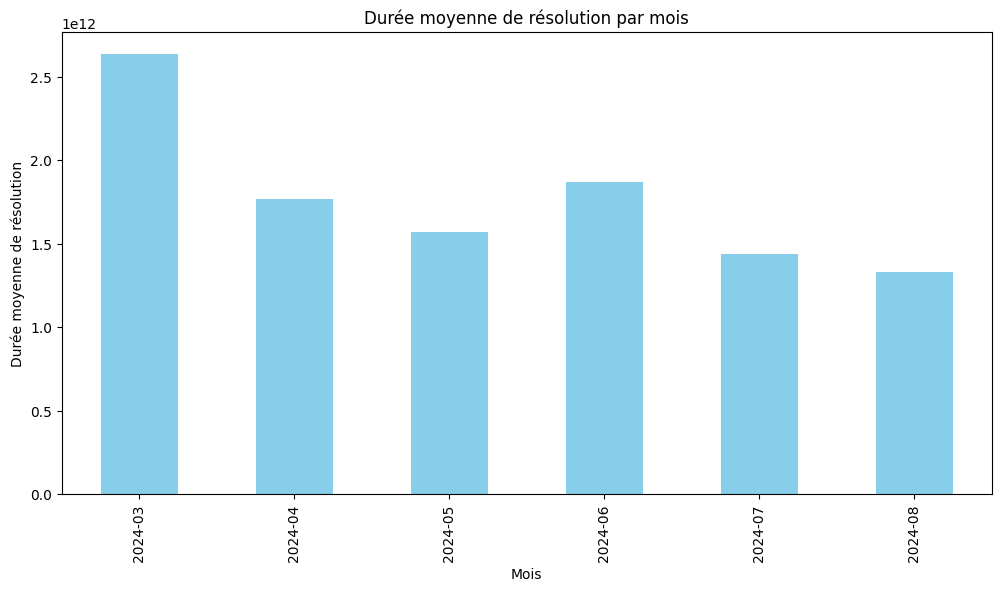

In [29]:
# Ajouter une colonne pour le mois
filtered_df['month'] = filtered_df['begin_date'].dt.to_period('M')

# Calculer la durée moyenne par mois
average_duration_per_month = filtered_df.groupby('month')['duration'].mean()

# Tracer les données
plt.figure(figsize=(12, 6))
average_duration_per_month.plot(kind='bar', color='skyblue')

# Ajouter des titres et des étiquettes
plt.title('Durée moyenne de résolution par mois')
plt.xlabel('Mois')
plt.ylabel('Durée moyenne de résolution')

# Afficher le graphique
plt.show()

## Trouver différents types incidents (non supervisé)

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(tweet_normaux_incidents['content_cleand_str'])


inertia = []
for k in range(2,60):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(inertia)
x = range(1, len(inertia)+1)
kn = KneeLocator(x, inertia, curve='convex', direction='decreasing')
print(kn.knee)

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyboardInterrupt: 

In [218]:
from sentence_transformers import SentenceTransformer

#model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2') ## 9 clusters, avec 1 ou 2 peu cohérents
model = SentenceTransformer('intfloat/multilingual-e5-base') ## 9 clusters, un peu mieux, toujours 1 ou 2 peu cohérents
#model = SentenceTransformer('dangvantuan/sentence-camembert-large') ## 8 clusters, plutot bon, 1 cluster bullshit
#model = SentenceTransformer('sentence-transformers/LaBSE') ## 11 clusters, plutot bons, 2~3 clusters bullshit
#model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2') ## 8 clusters, plutot bons, 1 cluster bullshit


## Solution = cleaner encore plus les texte car certains ne sont pas des tweets d'incidents

In [219]:
tweet_incidents = df_f[df_f['is_problem']==True]
tweet_normaux_incidents = tweet_incidents[tweet_incidents['tweet_type']=='Normal']


#df_vectors = model.encode(tweet_normaux_incidents['content_cleand_str'].values)
df_vectors = model.encode(tweet_normaux_incidents['content_removed_gare'].values)

In [220]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)  # Vous pouvez ajuster le nombre de composantes principales
principal_components = pca.fit_transform(df_vectors)


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.4, min_samples=1).fit(principal_components)
clustering.labels_

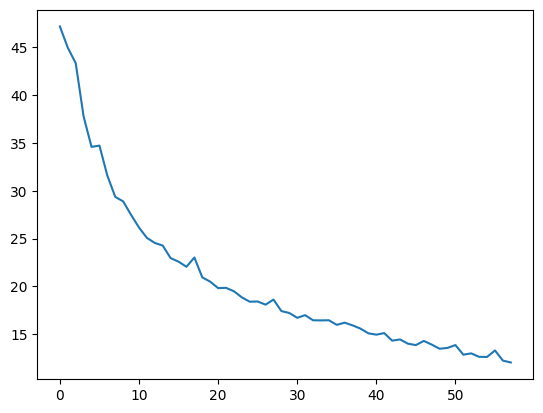

In [221]:
from sklearn.cluster import KMeans


inertia = []
for k in range(2,60):
    kmeans = KMeans(n_clusters=k, n_init='auto', max_iter=5000, tol=1e-6)
    kmeans.fit(principal_components)
    inertia.append(kmeans.inertia_)

plt.plot(inertia)

In [222]:
from kneed import KneeLocator

x = range(1, len(inertia)+1)
kn = KneeLocator(x, inertia, curve='convex', direction='decreasing')
print(kn.knee)

5


In [223]:
kmeans = KMeans(n_clusters=14, n_init='auto')
kmeans.fit(principal_components)

tweet_normaux_incidents['cluster'] = kmeans.labels_

C:\Users\gabriel\AppData\Local\Temp\ipykernel_25088\135117694.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_normaux_incidents['cluster'] = kmeans.labels_


In [224]:
tweet_normaux_incidents.groupby(['nb_gare_detected', 'cluster']).size()

nb_gare_detected  cluster
1                 1            7
                  2            4
                  3           11
                  4            1
                  5            2
                  6            6
                  7            2
                  8            1
                  9            5
                  10           3
                  12           1
2                 1           97
                  2            2
                  3            4
                  4          122
                  5           25
                  6            7
                  7          104
                  8            3
                  9           32
                  10          10
                  11          29
                  12           5
                  13          21
3                 0            1
                  1            3
                  2           21
                  3           54
                  4            4
                 

In [248]:
content = tweet_normaux_incidents[tweet_normaux_incidents['cluster']==13]['content_cleand_str'].values
print(content)


['bagage oublie' 'bagage oublie' 'bagage oublie quai' 'bagage oublie quai'
 'bagage oublie' 'bagage oublie' 'bagage oublie' 'bagage oublie'
 'bagage oublie bord' 'deux sens circulation bagage oublie'
 'bagage oublie' 'saint christophe bagage oublie' 'bagage oublie'
 'bagage oublie' 'bagage oublie quai' 'bagage oublie' 'bagage oublie quai'
 'bagage oublie' 'bagage oublie' 'bagage oublie' 'bagage oublie'
 'bagage oublie' 'quai bagage oublie' 'bagage oublie' 'bagage oublie'
 'bagage oublie' 'bagage oublie' 'bagage oublie' 'bagage oublie'
 'bagage oublie' 'bagage oublie']


## Trouver cluster lda

In [193]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import gensim


tweet_incidents = df_f[df_f['is_problem']==True]
tweet_normaux_incidents = tweet_incidents[tweet_incidents['tweet_type']=='Normal']

id2word = corpora.Dictionary(tweet_normaux_incidents['content_cleand_str'].apply(lambda x: x.split()))  
# Create Corpus 
texts = tweet_normaux_incidents['content_cleand_str'].apply(lambda x: x.split())  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 

coherence = []
for num_topics in range(2,40):
    print(num_topics)
    lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, passes=10, workers=2)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence.append(coherence_lda)

2
3


KeyboardInterrupt: 

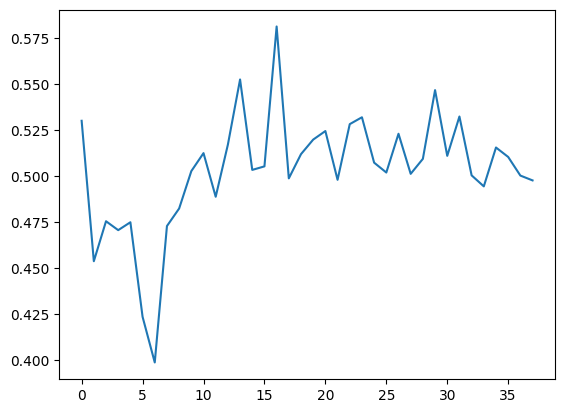

In [273]:
plt.plot(coherence)

In [274]:
tweet_incidents = df_f[df_f['is_problem']==True]
tweet_normaux_incidents = tweet_incidents[tweet_incidents['tweet_type']=='Normal']

id2word = corpora.Dictionary(tweet_normaux_incidents['content_cleand_str'].apply(lambda x: x.split()))  
# Create Corpus 
texts = tweet_normaux_incidents['content_cleand_str'].apply(lambda x: x.split())  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  

lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=16, random_state=42, passes=10, workers=2)

In [275]:
tweet_topics = []
for i, tweet_bow in enumerate(corpus):
    topics = lda_model.get_document_topics(tweet_bow)
    # Trouver le topic avec la probabilité la plus élevée
    main_topic = max(topics, key=lambda x: x[1])
    tweet_topics.append(main_topic[0])

# Ajouter les topics au DataFrame
tweet_normaux_incidents['main_topic'] = tweet_topics


C:\Users\gabriel\AppData\Local\Temp\ipykernel_20472\3912071561.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_normaux_incidents['main_topic'] = tweet_topics


In [276]:
tweet_normaux_incidents.groupby('main_topic').size()

main_topic
1       6
2      61
3      34
4       3
5      78
6       3
7       6
8       5
9     117
10      7
11     21
12     89
13      1
14      8
15     32
dtype: int64

In [277]:
tweet_normaux_incidents.groupby('main_topic').size()
for idx, topic in lda_model.print_topics(-1):
    terms = [term.split('*')[1].replace('"', '').strip() for term in topic.split(' + ')]
    print(f"Topic {idx}:")
    print(", ".join(terms))
    print("\n")

Topic 0:
terminus, affcetant, desservi, actionnement, signal, alarme, incident, voie, retabli, bagage


Topic 1:
stationnent, voies, personnes, incident, reprendra, regulier, fin, intervalle, ajustement, retour


Topic 2:
bagage, oublie, stationnent, tres, reprend, progressivement, bord, stationnement, difficultes, voie


Topic 3:
incident, technique, voyageur, journee, trajet, pendant, portee, rester, permettra, main


Topic 4:
incident, avril, passe, expliquons, retour, blog, matin, tout, ici, intervention


Topic 5:
incident, exploitation, voyageur, difficultes, voyageurs, incidents, panne, maximum, informer, puissent


Topic 6:
quai, stationnent, bagage, oublie, personne, presence, voies, circulation, deux, sens


Topic 7:
panne, retabli, incident, electrique, lie, termine, stationnent, dun, desservie, rerao


Topic 8:
stationnement, voyageurs, altercation, deux, malaises, signal, alarme, actionnement, abusif, difficultes


Topic 9:
alarme, signal, actionnement, incident, intervent

In [283]:
tweet_normaux_incidents[tweet_normaux_incidents['main_topic']==5]['content_cleand_str'].values

array(['incident exploitation', 'incident exploitation', 'inondations',
       'incident voyageur', 'incident exploitation', 'incident voyageur',
       'incident voyageur', 'incident voyageur', 'incident exploitation',
       'incident voyageur', 'incident voyageur', 'incident voyageur',
       'incident exploitation', 'incident exploitation',
       'incident exploitation', 'incident exploitation',
       'incident voyageur', 'incident exploitation',
       'incident exploitation', 'incident voyageur',
       'incident exploitation', 'incident exploitation',
       'incident exploitation', 'incident exploitation',
       'incident exploitation', 'incident exploitation',
       'incident exploitation', 'incident exploitation',
       'incident exploitation', 'incident voyageur',
       'incident voyageur panne',
       'stationnement difficultes exploitation',
       'incident voyageur garconnet jambe bloquee quai',
       'incident voyageur',
       'mardiconseil parmi incidents lies

## Trouver les différents types d'incidents (manuel classification)

In [210]:
import pandas as pd
import sys

df_f = pd.read_csv("df_f.csv")


for i,row in df_f.iterrows():
    
    if row['tweet_type']!='Normal':
        continue

    print(row['content'])
    sys.stdout.flush()  # Forcer le vidage du tampon de sortie

    is_problem = row['is_problem']
    label = row['label']
    print("----")
    is_problem_user = input(f"Est-ce un problème pour la ligne {i} (oui/non) ? ({is_problem}) : ")
    label_user = input(f"Entrez le label pour la ligne {i} {label} ")

    df_f.at[i, 'is_problem'] = is_problem_user.lower() == 'oui'
    df_f.at[i, 'label'] = label_user


    df_f.to_csv("df_f.csv", index=False)

exploitation
alarme
agent
bagage
sur_voie
malaise
conducteur
technique
inondation
arbre
altercation
aff_voie
ferm_porte
train_panne
accident_pers
panne_elec
signalisation
panne_train
voyageur
panne_porte
police
sortie_garage
catenaire
ajustement_interv
rallong_chantier
degradation

 Le trafic est perturbé de Poissy vers Nanterre - Préfecture , en raison d'un incident d'exploitation à Poissy #RERA
----
 Le train stationne à Gare de Lyon en direction de Cergy–Le Haut en raison de l'actionnement d'un signal d'alarme. #RERA
----
Le trafic est perturbé de Boissy-saint-Léger vers la Varennes-Chennevières, en raison d'un incident d'exploitation à Boissy-Saint-Léger. #RERA
----
Le train actuellement à Auber et en direction de Boissy-Saint-Léger stationne en raison de l'intervention des agents. #RERA
----
[#NouvelArticle ] Saviez-vous que les fortes chaleurs peuvent impacter nos infrastructures ainsi que notre matériel roulant ? Découvrez tout dans le nouvel article du blog #RERA ici 
----
Le train actuellement à Val de Fontenay et en direction de Marne-la-Vallée–Chessy stationne en raison de l'intervention des agents. #RERA
----
 Les trains ne marquent pas l'arrêt en gare de Nanterre – Préfecture en direction de Saint-Germain-en-Laye (bagage oublié). #RERA
----
 Le trafi

KeyboardInterrupt: Interrupted by user

In [216]:
df_f = pd.read_csv("df_f.csv")
df_f.replace("alrme", "alarme", inplace=True)
df_f.replace("train_panne", "panne_train", inplace=True)
df_f.head()

,tweet_type,time_posted,content,associated_tweet_id,comments,retweets,likes,views,extraction_date,tweet_id,...,content_removed_gare,content_removed_sw,content_cleand_str,word_counts,bigram_counts,trigram_counts,is_problem,date,engagement,label
0,Normal,2024-08-03 18:47:13,Le trafic est perturbé de Poissy vers Nanterr...,NaN,3,4,7,9272,2024-08-04 11:30:25.868093,e392794b-bde4-47b6-8c06-b4a44fcecbbe,...,le trafic est perturbe de vers en raison d ...,"['trafic', 'perturbe', 'raison', 'incident', '...",trafic perturbe raison incident exploitation,"Counter({'trafic': 1, 'perturbe': 1, 'raison':...","Counter({('trafic', 'perturbe'): 1, ('perturbe...","Counter({('trafic', 'perturbe', 'raison'): 1, ...",True,2024-08-03 18:47:13,0.150992,exploitation
1,Réponse,2024-08-03 19:09:26,Le trafic est perturbé de Nanterre - Préfectur...,NaN,2,0,1,6232,2024-08-04 11:30:37.644244,e392794b-bde4-47b6-8c06-b4a44fcecbbe,...,le trafic est perturbe de vers en raison d u...,"['trafic', 'perturbe', 'raison', 'incident', '...",trafic perturbe raison incident exploitation,"Counter({'trafic': 1, 'perturbe': 1, 'raison':...","Counter({('trafic', 'perturbe'): 1, ('perturbe...","Counter({('trafic', 'perturbe', 'raison'): 1, ...",True,2024-08-03 19:09:26,0.048139,NaN
2,Réponse,2024-08-03 19:53:27,Le trafic est rétabli de Nanterre–Préfecture ...,NaN,1,0,3,4170,2024-08-04 11:30:37.842704,e392794b-bde4-47b6-8c06-b4a44fcecbbe,...,le trafic est retabli de vers incident d ex...,"['trafic', 'retabli', 'incident', 'exploitation']",trafic retabli incident exploitation,"Counter({'trafic': 1, 'retabli': 1, 'incident'...","Counter({('trafic', 'retabli'): 1, ('retabli',...","Counter({('trafic', 'retabli', 'incident'): 1,...",True,2024-08-03 19:53:27,0.095923,NaN
3,Normal,2024-08-03 14:35:52,Le train stationne à Gare de Lyon en directio...,NaN,6,1,6,9031,2024-08-04 11:30:38.271172,76b5ed98-bfa0-4636-a87a-5c4540151eaf,...,le train stationne a en direction de en rai...,"['stationne', 'raison', 'actionnement', 'signa...",stationne raison actionnement signal alarme,"Counter({'stationne': 1, 'raison': 1, 'actionn...","Counter({('stationne', 'raison'): 1, ('raison'...","Counter({('stationne', 'raison', 'actionnement...",True,2024-08-03 14:35:52,0.143949,alarme
4,Réponse,2024-08-03 14:42:08,Le train est reparti de Gare de Lyon en direc...,NaN,1,0,3,1768,2024-08-04 11:30:49.952408,76b5ed98-bfa0-4636-a87a-5c4540151eaf,...,le train est reparti de en direction de en ...,"['reparti', 'repercussion', 'actionnement', 's...",reparti repercussion actionnement signal alarme,"Counter({'reparti': 1, 'repercussion': 1, 'act...","Counter({('reparti', 'repercussion'): 1, ('rep...","Counter({('reparti', 'repercussion', 'actionne...",True,2024-08-03 14:42:08,0.226244,NaN


In [239]:
last_index = df_f["label"].dropna().index[-1]

for i, row in df_f.iterrows():
    if i < last_index and isinstance(row["label"], float):
        df_f.at[i, 'label'] = 'no_label'


In [250]:
valid = df[0:last_index-1]
valid = valid[valid['tweet_type']=='Normal']

In [313]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder




vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(valid['content_cleand_str'])

# Convert sparse matrix to dense array
X = X.toarray()

# Encode the labels (y) using OneHotEncoder
label_encoder = OneHotEncoder()
y = label_encoder.fit_transform(valid[['label']]).toarray()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train a logistic regression model
model = RandomForestClassifier(n_estimators=100, max_depth=60)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")


Accuracy: 0.8085106382978723


## Classification zero shot

In [200]:
tweet_incidents = df_f[df_f['is_problem']==True]
tweet_normaux_incidents = tweet_incidents[tweet_incidents['tweet_type']=='Normal']
tweet_normaux_incidents.loc[0, 'content']

" Le trafic est perturbé de Poissy vers Nanterre - Préfecture , en raison d'un incident d'exploitation à Poissy #RERA"

In [23]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli")
sequence_to_classify = tweet_normaux_incidents.loc[0, 'content']
candidate_labels = [
    "exploitation",
    "alarme",
    "agent",
    "bagage",
    "sur_voie",
    "malaise",
    "conducteur",
    "technique",
    "inondation",
    "arbre",
    "altercation",
    "aff_voie",
    "ferm_porte",
    "train_panne",
    "accident_pers",
    "panne_elec",
    "signalisation",
    "panne_train",
    "voyageur",
    "panne_porte",
    "police",
    "sortie_garage",
    "catenaire",
    "ajustement_interv",
    "rallong_chantier",
    "degradation"
]
output = classifier(sequence_to_classify, candidate_labels, multi_label=False)
print(output)

{'sequence': " Le trafic est perturbé de Poissy vers Nanterre - Préfecture , en raison d'un incident d'exploitation à Poissy #RERA", 'labels': ['exploitation', 'altercation', 'sur_voie', 'accident_pers', 'alarme', 'panne_porte', 'ajustement_interv', 'rallong_chantier', 'agent', 'voyageur', 'signalisation', 'ferm_porte', 'degradation', 'police', 'malaise', 'aff_voie', 'catenaire', 'technique', 'conducteur', 'arbre', 'panne_train', 'train_panne', 'sortie_garage', 'bagage', 'panne_elec', 'inondation'], 'scores': [0.4789467453956604, 0.2436993271112442, 0.11318320035934448, 0.01874450594186783, 0.01827421598136425, 0.013358556665480137, 0.011777183972299099, 0.011108889244496822, 0.010000101290643215, 0.00907270610332489, 0.007801157422363758, 0.007282556034624577, 0.0067369709722697735, 0.0059247915633022785, 0.005436530336737633, 0.00538730388507247, 0.005326096434146166, 0.00505521846935153, 0.003938476089388132, 0.00374523364007473, 0.003055374138057232, 0.0027391952462494373, 0.002687

## Classification manuelle (aidé de vectorisation)

In [31]:
labels = {
"bagage oublie": ["bagage oublie"],
"signal alarme": ["actionnement signal alarme", "signal alarme"],
"signalisation" : ['panne signalisation', 'incident signalisation'],
"porte" : ['panne porte', 'panne portes', 'gene fermeture portes'],
"panne electrique": ['panne electrique'],
'incident exploitation': ['difficultés exploitation', 'difficultes exploitation', 'incident exploitation', 'incident explitation'],
"incident technique": ['incident technique', 'intervention services techniques'],
"intervention personnel": ['intervention agents', 'intervention conducteur', 'forces ordre', 'intervention equipes techniques'],
"voyageur": ['accident grave personne', 'acte malveillance', 'malaise voyageur', 'malaises voyageurs', 'incident voyageur', 'altercation voyageurs', 'bagarre voyageurs', 'degradation volontaire'],
"voies": ['personne voies', 'arbre voies', 'incident affectant voie', 'personnes voies', 'incident affcetant voie', 'voie occupee', 'animal voies'],
"catenaires" : ['chute catenaires', 'rupture catenaire', 'chute catenaire'],
"divers" : ['inondations', "incident informatique", "sortie garage"],
"ajustement intervalle" : ['ajustement intervalle'],
"degagement fumee": ['degagement fumee'],
"regulation":['mesures regulation'],
"mesure securite": ['mesure securite', 'mesures securite'],
"police": ['demande prefecture police', 'demande prefpolice', 'ordre prefecture police'],
"chantier": ['rallongement duree chantier', 'fin tardive chantier'],
"affluence exceptionnelle": ['affluence exceptionnelle'],
"panne train" : ["panne de train", "panne train", "panne"],
}

In [32]:
df_f[(df_f['is_problem']==True) & (df_f['tweet_type']=='Normal')].shape

(828, 22)

In [33]:
df_f ['label'] = ""
for index, row in df_f.iterrows():
    #if row['is_problem']==True and row['tweet_type']=='Normal':
    if row['tweet_type']=='Normal':
        text = row['content_cleand_str']
        label_associe = []
        for label in labels:
            for word in labels[label]:
                if word in text:
                    text = text.replace(word, '')
                    label_associe.append(label)
                    
        
        df_f.at[index, 'label'] = ",".join(label_associe)

In [34]:
df_f['len_label'] = df_f['label'].apply(lambda x: 0 if x=="" else len(x.split(',')))

In [35]:
df_f[df_f['tweet_type']=="Normal"].groupby('len_label').size()

len_label
0    103
1    820
2      8
dtype: int64

In [36]:
df_f[(df_f['tweet_type']=="Normal") & (df_f['len_label']==0)][['content', 'content_cleand_str']].values

array([['[#NouvelArticle ] Saviez-vous que les fortes chaleurs peuvent impacter nos infrastructures ainsi que notre matériel roulant ? Découvrez tout dans le nouvel article du blog #RERA ici ',
        'nouvelarticle saviez fortes chaleurs peuvent impacter infrastructures ainsi materiel roulant decouvrez tout nouvel article blog ici'],
       ["Des distributions d'eau  sont prévues aujourd'hui dans vos gares #RERA de :\nLa Défense à 13h et 17h\nChâtelet-Les Halles à 18h30\nGare de Lyon à 16h30\nNation à 15h30\nVincennes à 16h\nBussy-Saint-Georges à 13h \nMarne-la-Vallée-Chessy à 15h",
        'distributions eau prevues aujourd hui gares'],
       ["Des distributions d'eau  sont prévues aujourd'hui dans vos gares #RERA de :\nLa Défense à 13h et 17h\nChâtelet-Les Halles à 15h30\nGare de Lyon à 16h30\nNation à 18h30\nVincennes à 16h30\nBussy-Saint-Georges à 13h et à 19h\nMarne-la-Vallée-Chessy à 15h",
        'distributions eau prevues aujourd hui gares'],
       ["[Fortes chaleurs ] : Pe

## Trouver la gare source du problème

In [37]:
df_f.groupby(['label', 'nb_gare_detected']).size()

label                 nb_gare_detected
                      1                   442
                      2                   500
                      3                   340
                      4                   137
                      5                    52
                                         ... 
voyageur              3                    29
                      4                     9
                      5                     4
voyageur,panne train  2                     1
voyageur,voyageur     2                     1
Length: 84, dtype: int64

In [38]:
df_f[(df_f['tweet_type']=="Normal") & (df_f['len_label']>0)]['content'].values

array([" Le trafic est perturbé de Poissy vers Nanterre - Préfecture , en raison d'un incident d'exploitation à Poissy #RERA",
       " Le train stationne à Gare de Lyon en direction de Cergy–Le Haut en raison de l'actionnement d'un signal d'alarme. #RERA",
       "Le trafic est perturbé de Boissy-saint-Léger vers la Varennes-Chennevières, en raison d'un incident d'exploitation à Boissy-Saint-Léger. #RERA",
       "Le train actuellement à Auber et en direction de Boissy-Saint-Léger stationne en raison de l'intervention des agents. #RERA",
       "Le train actuellement à Val de Fontenay et en direction de Marne-la-Vallée–Chessy stationne en raison de l'intervention des agents. #RERA",
       " Les trains ne marquent pas l'arrêt en gare de Nanterre\u2006–\u2006Préfecture en direction de Saint-Germain-en-Laye (bagage oublié). #RERA",
       " Le trafic est perturbé de La Défense vers Cergy-Le Haut • Poissy et Saint-Germain-en-Laye en raison d'un bagage oublié sur le quai à Nanterre\u2006–

In [39]:
gare_source_regex = [
    "stationne à (.*)en raison", 
    "actuellement à (.*) en raison", 
    "ne marquent pas l arret en gare de (.*)",
    "stationne a .* en raison",
    "stationne au .* en raison",
    "stationnement .*? a .* en raison",
    "actuellement .* en raison",
    "en raison .*? a .{10,}",
    "en raison .*? gare .*",
    "est perturbe de (.*)",
    "est perturbe a .* en raison",
    "intervention .*? a .*",
    "en repercussion .*? a .*",
    "stationne .*? a .*",
    "gare .*? en repercussion .*? sur le quai",
    "cela fait suite .*? a .*",
    "panne a .*",
    ]

df_f['gare_source'] = ""
for index, row in df_f.iterrows():
    if row['tweet_type']=='Normal':
        for regex in gare_source_regex:
            match = re.search(regex, row['content_cleaned'])
            if match:
                
                current_text = match.group(0)
                cursor_deb = 0
                cursor_end = 1

                gare_detected = []

                while cursor_end < len(current_text):

                    gare, gare_key = find_gare(current_text[cursor_deb:cursor_end])

                    if gare is None:
                        cursor_end += 1
                    else:
                        gare, cursor_end = find_max_len_gare_from_key(gare_key, gare, current_text, cursor_deb, cursor_end)
                        gare_detected.append(gare_key)
                        cursor_deb = cursor_end
                        cursor_end = cursor_deb + 1 

                print(current_text)
                df_f.loc[index, 'gare_source'] = gare_detected[0]
                break
            elif row['nb_gare_detected']==1:
                df_f.loc[index, 'gare_source'] = row['gare_detected']
                break


en raison d un incident d exploitation a poissy rera
stationne a gare de lyon en direction de cergy le haut en raison
en raison d un incident d exploitation a boissy saint leger rera
actuellement a auber et en direction de boissy saint leger stationne en raison
actuellement a val de fontenay et en direction de marne la vallee chessy stationne en raison
ne marquent pas l arret en gare de nanterre prefecture en direction de saint germain en laye bagage oublie rera
en raison d un bagage oublie sur le quai a nanterre prefecture rera
actuellement a nanterre prefecture et en direction de poissy stationne en raison
actuellement a la varenne chennevieres et en direction de boissy saint leger stationne en raison
actuellement a cergy prefecture et en direction de boissy saint leger stationne en raison
actuellement au parc saint maur et en direction de la defense stationne en raison
actuellement a boissy saint leger et en direction de cergy le haut stationne en raison
actuellement a gare de lyon 

In [40]:
df_f[(df_f['tweet_type']=='Normal') & (df_f['len_label']>0)].groupby(['gare_source']).size()

gare_source
                                18
Achères Grand Cormier            4
Achères Ville                   19
Auber                           44
Boissy-Saint-Léger              30
Bry-sur-Marne                   11
Bussy-Saint-Georges             15
Cergy le Haut                   35
Champigny                        6
Charles de Gaulle-Etoile        20
Chatou-Croissy                   2
Châtelet les Halles             46
Conflans Fin d'Oise              4
Fontenay-sous-Bois              25
Gare de Lyon                    44
Houilles-Carrières-sur-Seine    10
Joinville-le-Pont                4
La Défense                      36
La Varenne-Chennevières         23
Le Vésinet-Le Pecq               5
Lognes                           7
Maisons-Laffitte                17
Marne-la-Vallée-Chessy          29
Nanterre Préfecture             60
Nanterre Université              8
Nanterre Ville                  11
Nation                          24
Neuilly-Plaisance               13
Neuville

In [41]:
df_f[(df_f['tweet_type']=='Normal') & (df_f['len_label']>0) & (df_f['gare_source']=="Nanterre Préfecture")].content.values

array([" Les trains ne marquent pas l'arrêt en gare de Nanterre\u2006–\u2006Préfecture en direction de Saint-Germain-en-Laye (bagage oublié). #RERA",
       " Le trafic est perturbé de La Défense vers Cergy-Le Haut • Poissy et Saint-Germain-en-Laye en raison d'un bagage oublié sur le quai à Nanterre\u2006–\u2006Préfecture. #RERA",
       "Le train actuellement à Nanterre\u2006–\u2006Préfecture et en direction de Poissy stationne en raison d'un incident nécessitant l'intervention des agents. #RERA",
       "Le train actuellement à Nanterre\u2006–\u2006Préfecture et en direction de Cergy-le Haut stationne en raison de l'actionnement d'un signal d'alarme. #RERA",
       "Le trafic est ralenti de Nanterre-Préfecture vers Saint-Germain-en-Laye en raison d'un bagage oublié à Nanterre Préfecture #RERA",
       " Le trafic est perturbé de Nanterre\u2006–\u2006Préfecture vers Boissy-Saint-Léger en raison d'un incident d'exploitation à Nanterre\u2006–\u2006Préfecture. #RERA",
       "Un train st

In [42]:
df_f[(df_f['tweet_type']=='Normal') & (df_f['len_label']>0) & (df_f['nb_gare_detected']>1) & (df_f['gare_source']=="")][['content', 'content_cleaned']].values

array([[' Le trafic est interrompu entre Nation et Val de Fontenay, et entre Fontenay-sous-Bois et Nation (train en panne). Reprise estimée : 06:00. #RERA',
        ' le trafic est interrompu entre nation et val de fontenay et entre fontenay sous bois et nation train en panne reprise estimee rera'],
       [' Le trafic est interrompu entre Houilles Carrières-sur-Seine et Nanterre -Préfecture et perturbé sur le reste de la ligne (accident grave de personne). Reprise estimée : 07:30. #RERA',
        ' le trafic est interrompu entre houilles carrieres sur seine et nanterre prefecture et perturbe sur le reste de la ligne accident grave de personne reprise estimee rera'],
       ["Le trafic est interrompu entre Achères Ville et Maisons-Laffite en raison d'une chute de caténaire. La reprise est estimée vers 07h00. Le trafic est très perturbé sur le reste de la ligne. #RERA",
        'le trafic est interrompu entre acheres ville et maisons laffite en raison d une chute de catenaire la reprise

## Visualisation finale

### Nombre d'incidents par mois

In [43]:
incident_notifies = df_f[(df_f['tweet_type']=='Normal') & (df_f['len_label']>0)]
incident_notifies['date'] = pd.to_datetime(incident_notifies['time_posted'])

incident_par_mois = incident_notifies.groupby(incident_notifies['date'].dt.to_period('M')).size()
incident_par_jour = incident_notifies.groupby(incident_notifies['date'].dt.to_period('D')).size()

tweets_per_day_label = incident_notifies.groupby([incident_notifies['date'].dt.to_period('D'), 'label']).size().unstack(fill_value=0)
tweets_per_day_label.index = tweets_per_day_label.index.to_timestamp()

total_tweets_per_label = tweets_per_day_label.sum()
# Sélectionner les labels les plus nombreux (par exemple, les 5 premiers)
top_labels = total_tweets_per_label.nlargest(1).index


incident_par_mois.index = incident_par_mois.index.to_timestamp()
incident_par_jour.index = incident_par_jour.index.to_timestamp()

C:\Users\gabriel\AppData\Local\Temp\ipykernel_4364\3074638833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incident_notifies['date'] = pd.to_datetime(incident_notifies['time_posted'])


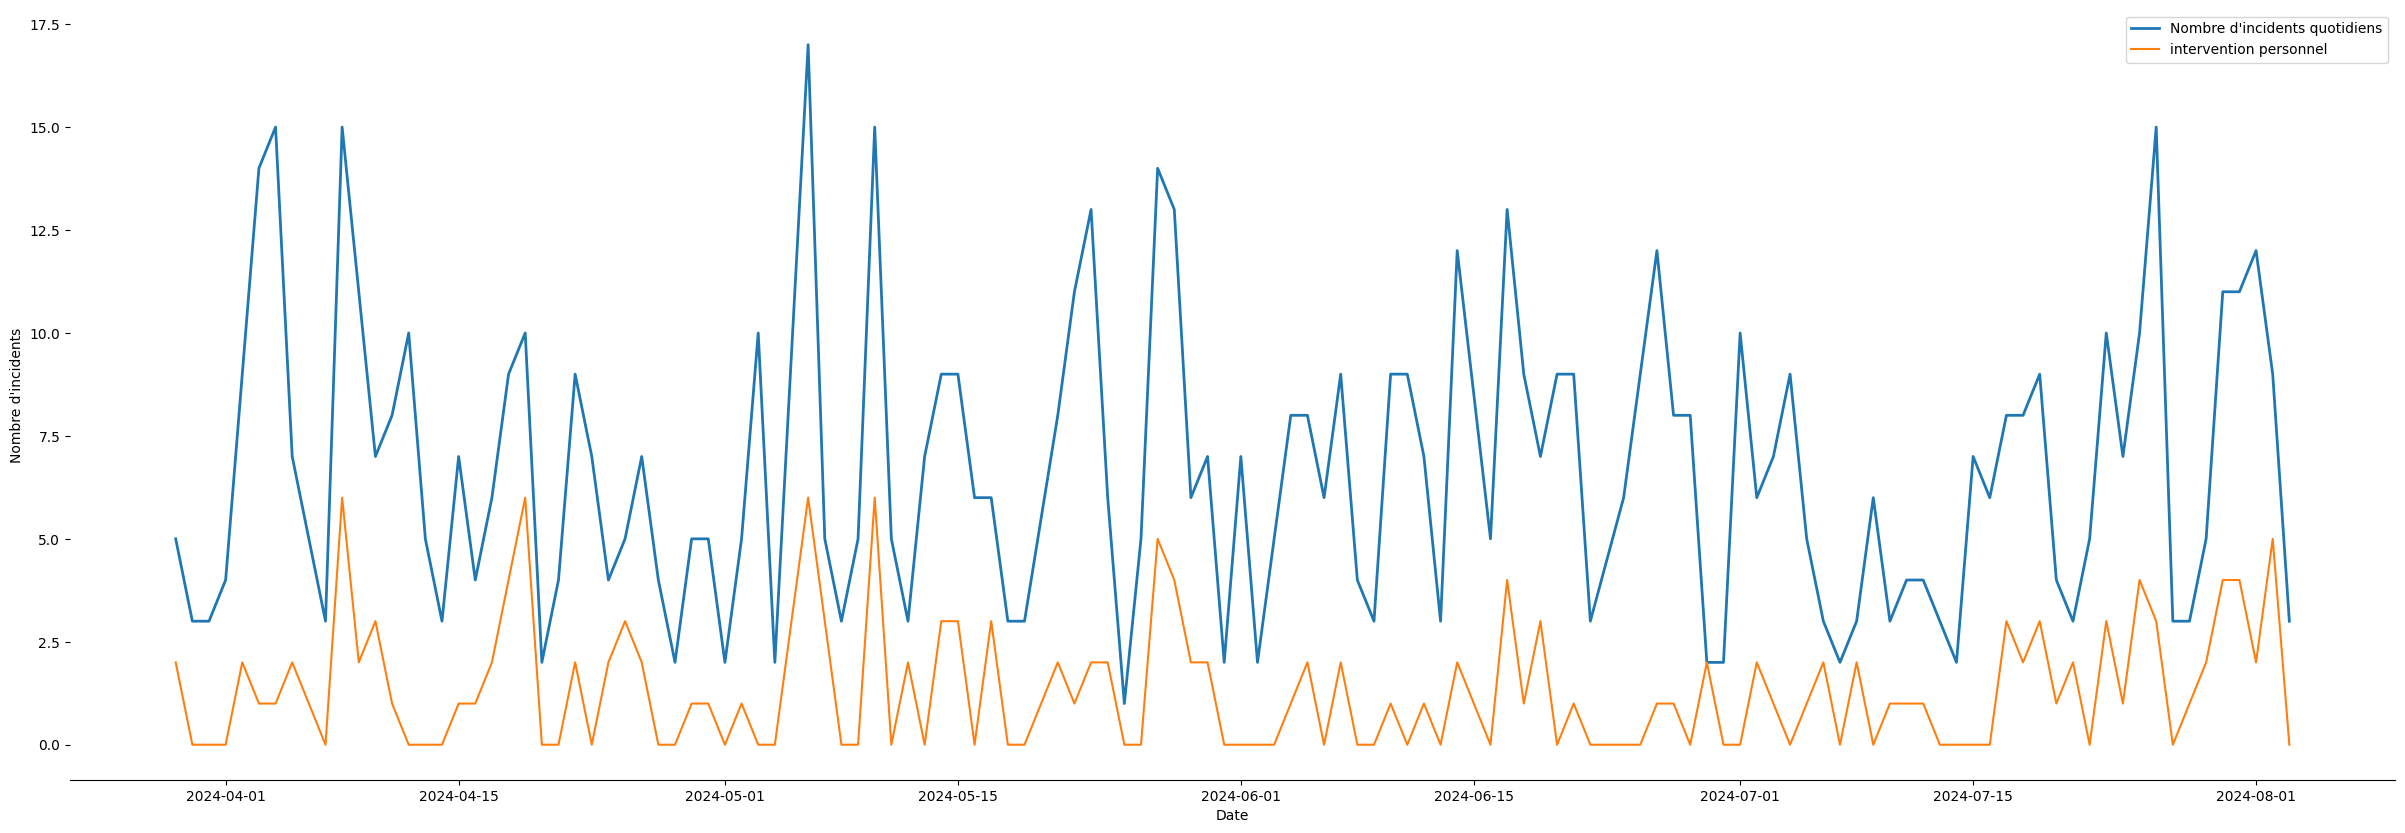

In [44]:
fig, ax = plt.subplots(
    figsize=(30, 10)
)

ax.plot(incident_par_jour.index, incident_par_jour.values, label="Nombre d'incidents quotidiens", linewidth=2)

for label in top_labels:
    ax.plot(tweets_per_day_label.index, tweets_per_day_label[label], label=label)


ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
#ax.spines["bottom"].set_bounds(min(incident_par_jour.index), max(incident_par_jour.index))

ax.set_xlabel("Date")
ax.set_ylabel("Nombre d'incidents")
plt.legend()
plt.show()

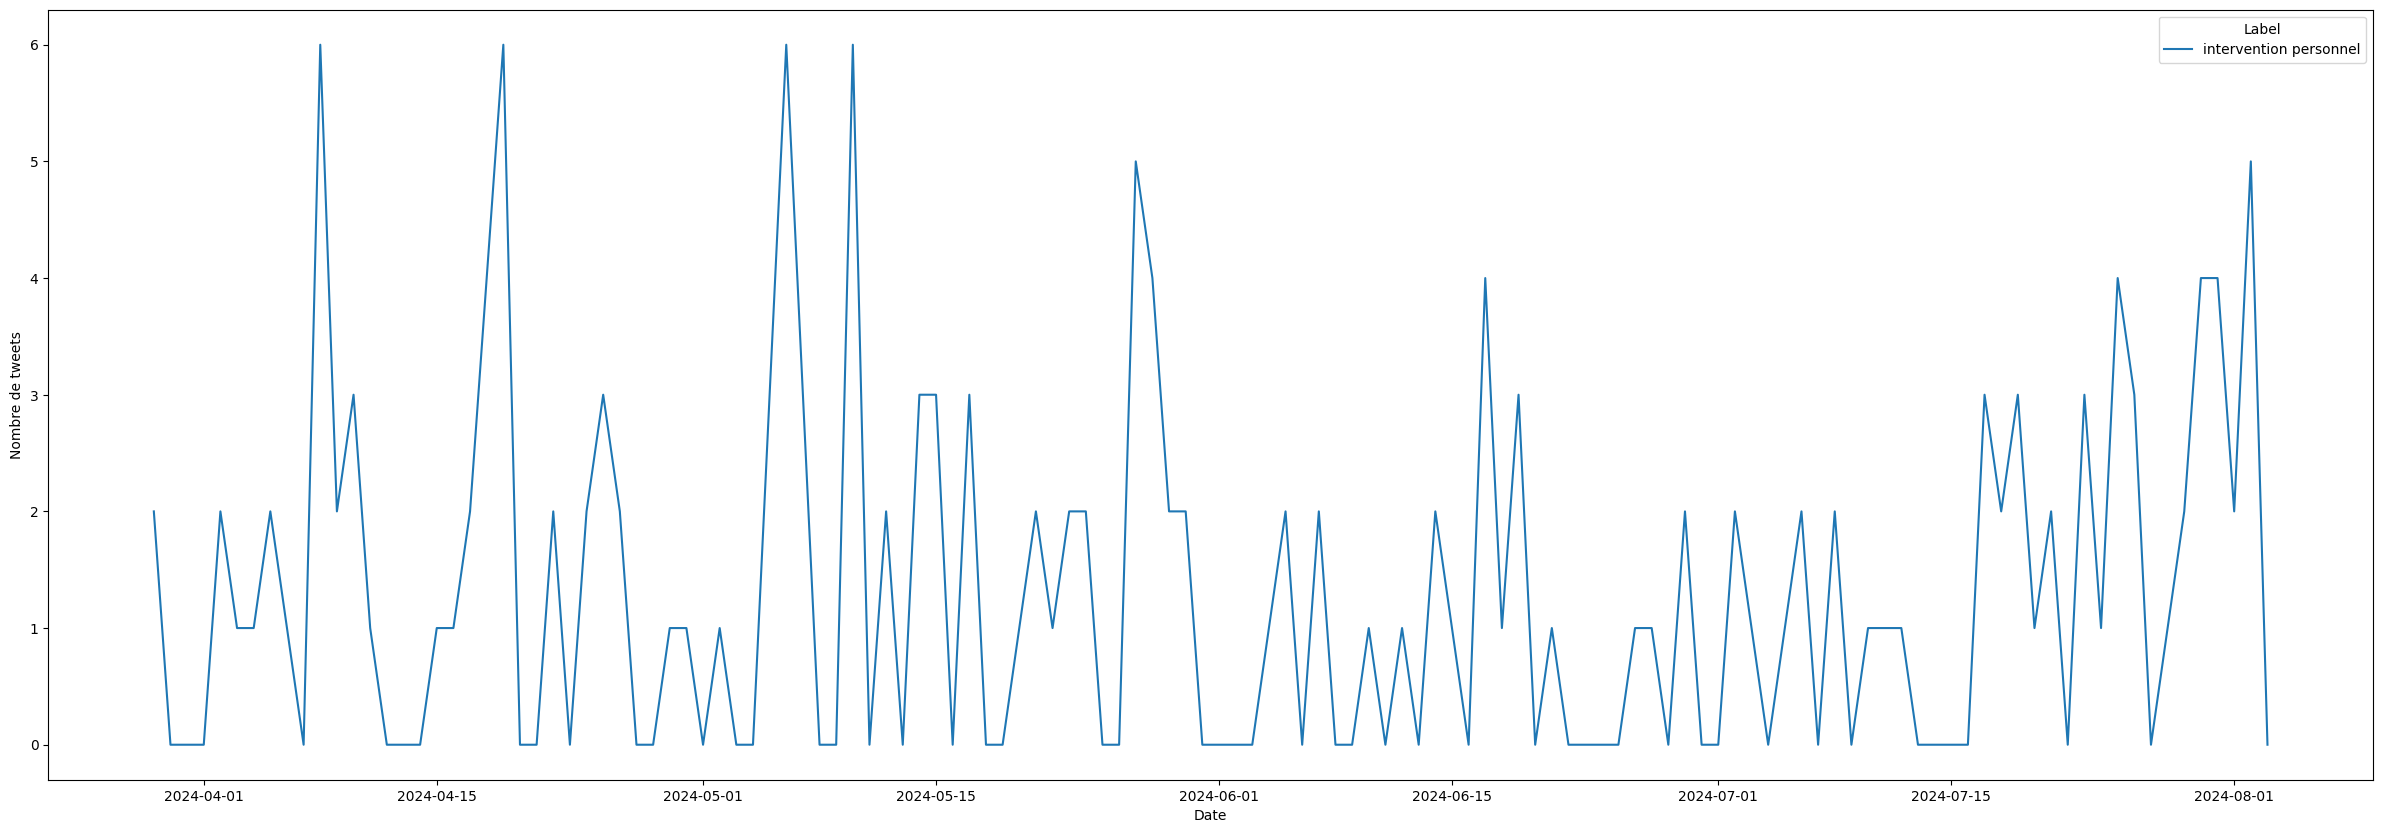

In [45]:
# Créer une figure et un axe
fig, ax = plt.subplots(figsize=(30, 10))

# Tracer les données pour chaque label parmi les plus nombreux
for label in top_labels:
    ax.plot(tweets_per_day_label.index, tweets_per_day_label[label], label=label)

# Ajouter des labels et une légende
ax.set_xlabel('Date')
ax.set_ylabel('Nombre de tweets')
ax.legend(title='Label')

# Afficher la figure
plt.show()

### Temps de résolutinon

### Sources des problèmes (gares)

In [46]:
incidents_notifies = df_f[(df_f['tweet_type'] == 'Normal') & (df_f['len_label'] > 0)]

# Grouper par gare (label) et compter le nombre total d'incidents
incidents_par_gare = incident_notifies.groupby('gare_source').size()


In [47]:
incidents_par_gare

gare_source
                                18
Achères Grand Cormier            4
Achères Ville                   19
Auber                           44
Boissy-Saint-Léger              30
Bry-sur-Marne                   11
Bussy-Saint-Georges             15
Cergy le Haut                   35
Champigny                        6
Charles de Gaulle-Etoile        20
Chatou-Croissy                   2
Châtelet les Halles             46
Conflans Fin d'Oise              4
Fontenay-sous-Bois              25
Gare de Lyon                    44
Houilles-Carrières-sur-Seine    10
Joinville-le-Pont                4
La Défense                      36
La Varenne-Chennevières         23
Le Vésinet-Le Pecq               5
Lognes                           7
Maisons-Laffitte                17
Marne-la-Vallée-Chessy          29
Nanterre Préfecture             60
Nanterre Université              8
Nanterre Ville                  11
Nation                          24
Neuilly-Plaisance               13
Neuville

In [48]:
gare_list = list(stations_rer_a_constant_dict.keys())

In [49]:
from matplotlib.font_manager import FontProperties

# Charger la police personnalisée
font_path = 'Parisine Bold.otf'
custom_font = FontProperties(fname=font_path)


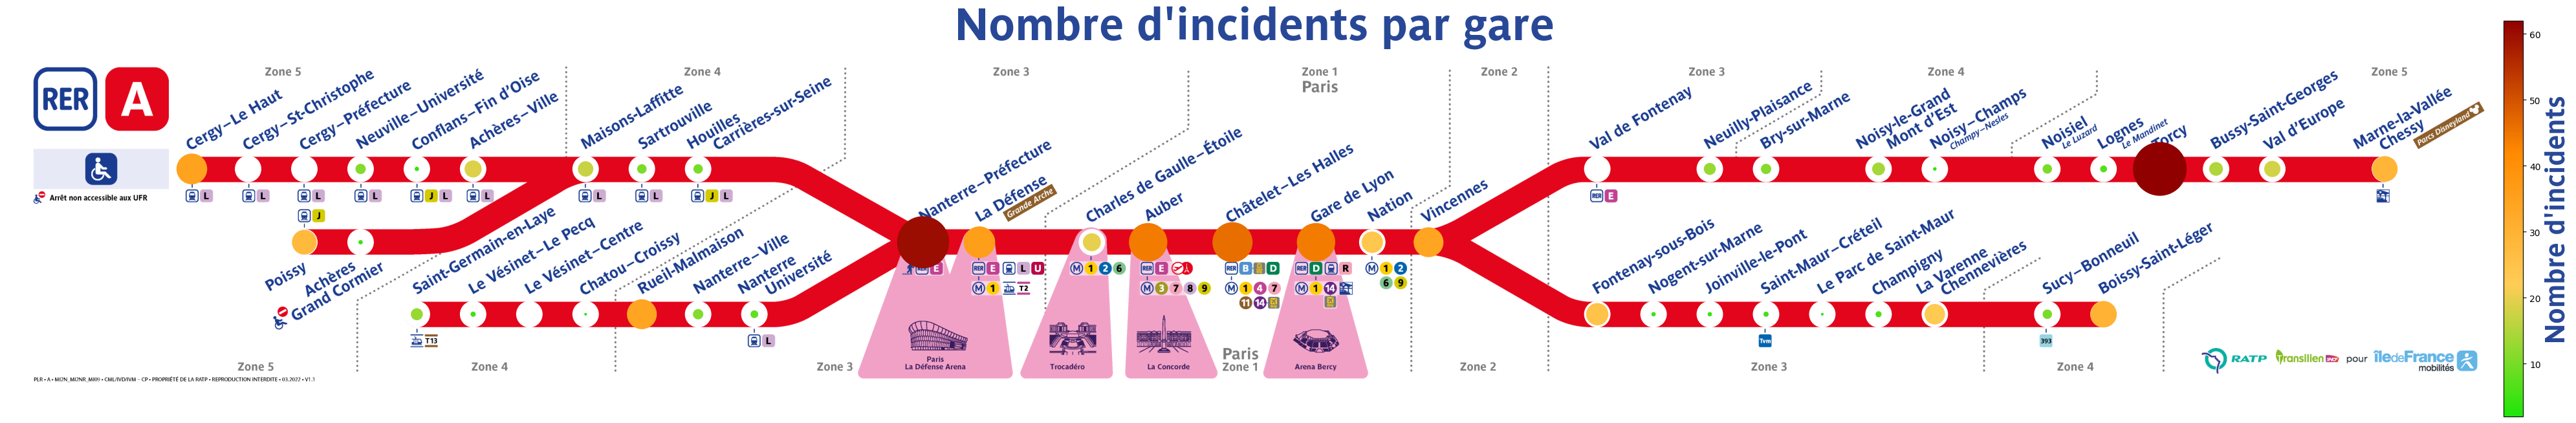

In [50]:
# Activer le mode d'affichage inline pour Matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Charger l'image de la ligne de métro
image_path = 'plan_rer__a.png'
img = Image.open(image_path)

# Créer une figure et un axe
img_width, img_height = img.size
fig, ax = plt.subplots(figsize=(img_width / 100, img_height / 100), dpi=100)

# Afficher l'image en arrière-plan
ax.imshow(img, extent=[0, img.width, 0, img.height])

# Exemple de données de gares avec leurs coordonnées et tailles
# Les coordonnées doivent être adaptées à l'échelle de l'image
line_y_1 = 514
line_y_2 = 342
line_y_3 = 173


x_beginning = 435
x_end = 5576
x_gap_space = 132
x_gare_lyon = x_beginning+(x_gap_space*17) + 2*197

gares = [
    {"name": "Cergy le Haut", "location": [x_beginning, line_y_1], "size": 3},
    {"name": "Cergy Saint-Christophe", "location": [x_beginning+x_gap_space, line_y_1], "size": 3},
    {"name": "Cergy Préfecture", "location": [x_beginning+(x_gap_space*2), line_y_1], "size": 3},
    {"name": "Neuville Université", "location": [x_beginning+(x_gap_space*3), line_y_1], "size": 3},
    {"name": "Conflans Fin d'Oise", "location": [x_beginning+(x_gap_space*4), line_y_1], "size": 3},
    {"name": "Achères Ville", "location": [x_beginning+(x_gap_space*5), line_y_1], "size": 3},
    {"name": "Maisons-Laffitte", "location": [x_beginning+(x_gap_space*7), line_y_1], "size": 3},
    {"name": "Sartrouville", "location": [x_beginning+(x_gap_space*8), line_y_1], "size": 3},
    {"name": "Houilles-Carrières-sur-Seine", "location": [x_beginning+(x_gap_space*9), line_y_1], "size": 3},

    {"name": "Poissy", "location": [x_beginning+(x_gap_space*2), line_y_2], "size": 3},
    {"name": "Achères Grand Cormier", "location": [x_beginning+(x_gap_space*3), line_y_2], "size": 3},

    {"name": "Saint-Germain-en-Laye", "location": [x_beginning+(x_gap_space*4), line_y_3], "size": 3},
    {"name": "Le Vésinet-Le Pecq", "location": [x_beginning+(x_gap_space*5), line_y_3], "size": 3},
    {"name": "Le Vésinet-Centre", "location": [x_beginning+(x_gap_space*6), line_y_3], "size": 3},
    {"name": "Chatou-Croissy", "location": [x_beginning+(x_gap_space*7), line_y_3], "size": 3},
    {"name": "Rueil-Malmaison", "location": [x_beginning+(x_gap_space*8), line_y_3], "size": 3},
    {"name": "Nanterre Ville", "location": [x_beginning+(x_gap_space*9), line_y_3], "size": 3},
    {"name": "Nanterre Université", "location": [x_beginning+(x_gap_space*10), line_y_3], "size": 3},


    {"name": "Nanterre Préfecture", "location": [x_beginning+(x_gap_space*13), line_y_2], "size": 3},
    {"name": "La Défense", "location": [x_beginning+(x_gap_space*14), line_y_2], "size": 3},

    {"name": "Charles de Gaulle-Etoile", "location": [x_beginning+(x_gap_space*16), line_y_2], "size": 3},
    {"name": "Auber", "location": [x_beginning+(x_gap_space*17), line_y_2], "size": 3},
    {"name": "Châtelet les Halles", "location": [x_beginning+(x_gap_space*17) + 198, line_y_2], "size": 3},
    {"name": "Gare de Lyon", "location": [x_gare_lyon, line_y_2], "size": 3},
    {"name": "Nation", "location": [x_gare_lyon+(x_gap_space*1), line_y_2], "size": 3},
    {"name": "Vincennes", "location": [x_gare_lyon+(x_gap_space*2), line_y_2], "size": 3},


    {"name": "Val de Fontenay", "location": [x_gare_lyon+(x_gap_space*5), line_y_1], "size": 3},
    {"name": "Neuilly-Plaisance", "location": [x_gare_lyon+(x_gap_space*7), line_y_1], "size": 3},
    {"name": "Bry-sur-Marne", "location": [x_gare_lyon+(x_gap_space*8), line_y_1], "size": 3},
    {"name": "Noisy-le-Grand-Mont d'Est", "location": [x_gare_lyon+(x_gap_space*10), line_y_1], "size": 3},
    {"name": "Noisy-Champs", "location": [x_gare_lyon+(x_gap_space*11), line_y_1], "size": 3},
    {"name": "Noisiel", "location": [x_gare_lyon+(x_gap_space*13), line_y_1], "size": 3},
    {"name": "Lognes", "location": [x_gare_lyon+(x_gap_space*14), line_y_1], "size": 3},
    {"name": "Torcy", "location": [x_gare_lyon+(x_gap_space*15), line_y_1], "size": 3},
    {"name": "Bussy-Saint-Georges", "location": [x_gare_lyon+(x_gap_space*16), line_y_1], "size": 3},
    {"name": "Val d'Europe", "location": [x_gare_lyon+(x_gap_space*17), line_y_1], "size": 3},
    {"name": "Marne-la-Vallée-Chessy", "location": [x_gare_lyon+(x_gap_space*19), line_y_1], "size": 3},


    {"name": "Fontenay-sous-Bois", "location": [x_gare_lyon+(x_gap_space*5), line_y_3], "size": 3},
    {"name":  "Nogent-sur-Marne", "location": [x_gare_lyon+(x_gap_space*6), line_y_3], "size": 3},
    {"name": "Joinville-le-Pont", "location": [x_gare_lyon+(x_gap_space*7), line_y_3], "size": 3},
    {"name": "Saint-Maur-Créteil", "location": [x_gare_lyon+(x_gap_space*8), line_y_3], "size": 3},
    {"name": "Parc de Saint-Maur", "location": [x_gare_lyon+(x_gap_space*9), line_y_3], "size": 3},
    {"name": "Champigny", "location": [x_gare_lyon+(x_gap_space*10), line_y_3], "size": 3},
    {"name": "La Varenne-Chennevières", "location": [x_gare_lyon+(x_gap_space*11), line_y_3], "size": 3},
    {"name": "Sucy-Bonneuil", "location": [x_gare_lyon+(x_gap_space*13), line_y_3], "size": 3},
    {"name": "Boissy-Saint-Léger", "location": [x_gare_lyon+(x_gap_space*14), line_y_3], "size": 3},

]


for gare in gares:
    circle = patches.Circle(
        (gare["location"][0], gare["location"][1]),
        radius=gare["size"] * 10,  # Ajuster le facteur de taille si nécessaire
        #color="#E3051B",
        color="white",
        fill=True,
        alpha=1
    )
    ax.add_patch(circle)

from matplotlib import cm
from matplotlib.colors import Normalize, LinearSegmentedColormap

# Normaliser les tailles des cercles pour qu'elles soient comprises entre 0 et 1
norm = Normalize(vmin=min(incidents_par_gare), vmax=max(incidents_par_gare))
# Choisir une colormap (par exemple, 'viridis', 'Reds', 'Blues', etc.)
#cmap = cm.get_cmap('plasma')

colors = ["#1FE609", "#FFCD56", "#FF8A00", "#910000"]  # Vert -> Noir
cmap = LinearSegmentedColormap.from_list("GreenBlack", colors)

for index, nb_incidents in enumerate(incidents_par_gare):
    gare_concernes = incidents_par_gare.index[index]

    for gare in gares:
        if gare_concernes in gare['name']:
            
            color = cmap(norm(nb_incidents))

            circle = patches.Circle(
                (gare["location"][0], gare["location"][1]),
                radius=nb_incidents,  # Ajuster le facteur de taille si nécessaire
                color=color,
                fill=True,
            )

            ax.add_patch(circle)
            break


from matplotlib.cm import ScalarMappable

# Ajouter une légende personnalisée
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0, aspect=20)
cbar.set_label("Nombre d'incidents", fontproperties=custom_font, size=30, color="#284897")

# Ajuster les limites de l'axe pour correspondre à l'image
ax.set_xlim(0, img.width)
ax.set_ylim(0, img.height)

# Supprimer les axes pour une meilleure visualisation
ax.axis('off')
plt.title("Nombre d'incidents par gare", fontproperties=custom_font, size=50, color="#284897")

# Afficher la figure
plt.show()


In [51]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
import plotly.graph_objs as go
from PIL import Image
import numpy as np

# Charger l'image de la ligne de métro
image_path = 'plan_rer__a.png'
img = Image.open(image_path)
img_width, img_height = img.size


# Normaliser les tailles des cercles
norm = Normalize(vmin=min(incidents_par_gare), vmax=max(incidents_par_gare))
colors = ["#1FE609", "#FFCD56", "#FF8A00", "#910000"]  # Vert -> Noir
cmap = LinearSegmentedColormap.from_list("GreenBlack", colors)



# Créer les traces pour les cercles
traces = []

for index, nb_incidents in enumerate(incidents_par_gare):
    gare_concernes = incidents_par_gare.index[index]

    for gare in gares:
        if gare_concernes in gare['name']:
            
            color = cmap(norm(nb_incidents))
            traces.append(go.Scatter(
                x=[gare["location"][0]],
                y=[gare["location"][1]],
                mode='markers',
                marker=dict(
                    size=(nb_incidents*20)/max(incidents_par_gare),  # Ajuster le facteur de taille si nécessaire
                    color=color,
                    line=dict(width=1, color='black')
                ),
                text=f"{gare['name']} - \nNombre d'incidents: {nb_incidents}",
                hoverinfo='text'
            ))

            
            break


# Créer la figure
fig = go.Figure(data=traces)

# Ajouter l'image en arrière-plan
fig.add_layout_image(
    dict(
        source=img,
        xref="x",
        yref="y",
        x=0,
        y=img_height,
        sizex=img_width,
        sizey=img_height,
        sizing="stretch",
        opacity=1,
        layer="below"
    )
)

# Ajuster les limites de l'axe pour correspondre à l'image
fig.update_xaxes(visible=False, range=[0, img_width])
fig.update_yaxes(visible=False, range=[0, img_height], scaleanchor="x")



# Ajouter une légende personnalisée
fig.update_layout(

    title=dict(
        text="Nombre d'incidents par gare",
        font=dict(size=30, color="#284897"),
        x=0.5,
        y=0.7,
        xanchor='center',
        yanchor='top'
    ),
    showlegend=False,

    margin=dict(l=0, r=0, t=0, b=0),  # Réduire les marges autour de l'image

)
fig.update_layout(font_family="Parisine Bold.otf")

fig.show()